In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
import pylab as plt
from sklearn.datasets import make_moons

from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import MultivariateNormal

## Illustrative 2D Example 

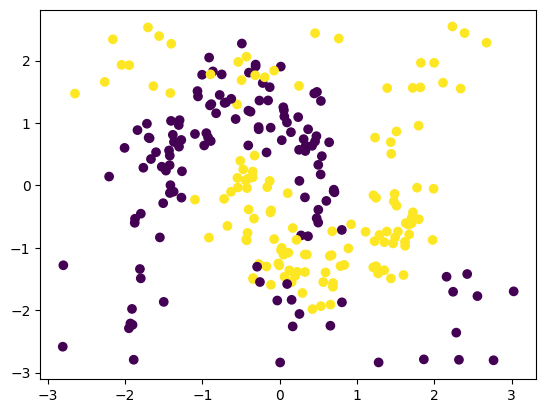

In [2]:
torch.manual_seed(1)
np.random.seed(42)
X, y = make_moons(200, noise=.2)
X = (X - X.mean(0)) / X.std(0)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
train_ds = TensorDataset(X, y)

X_new = torch.Tensor(10, 2).normal_(-3, 0.2).float()
y_new = torch.Tensor(10).zero_().long()
new_ds = TensorDataset(X_new, y_new)

X_new = torch.cat([
    MultivariateNormal(torch.tensor((-2., -2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor((-2.,  2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor(( 2., -2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor(( 2.,  2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor(( 0.,  2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
    MultivariateNormal(torch.tensor(( 0.,  -2.)), covariance_matrix=.2*torch.eye(2)).sample((10,)),
])
y_new = torch.cat([
    torch.Tensor(10).fill_(0),
    torch.Tensor(10).fill_(1),
    torch.Tensor(10).fill_(0),
    torch.Tensor(10).fill_(1),
    torch.Tensor(10).fill_(1),
    torch.Tensor(10).fill_(0),
]).long()
new_ds = TensorDataset(X_new, y_new)


plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.show()

### Kernel-based Update

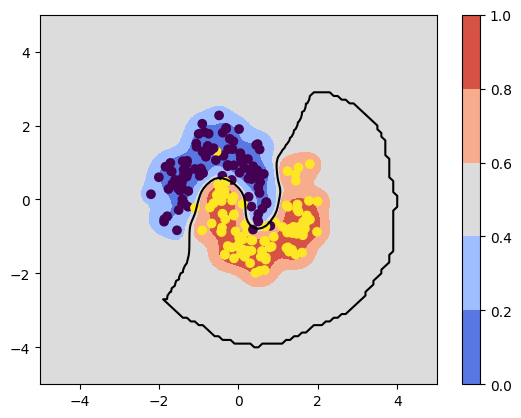

In [3]:
from sklearn.metrics import pairwise_kernels

def k_func(samples):
    S = pairwise_kernels(samples, X, metric='rbf', gamma=10)

    K = []
    for distances in S:
        prior=1

        k_vec = np.zeros(2) + prior
        for i_cls in range(2):
            dist_cls = distances[y == i_cls]
            inv_dist_cls = dist_cls
            inv_dist_cls[np.isinf(inv_dist_cls)] = 0
            k_vec[i_cls] += np.sum(inv_dist_cls)
        K.append(k_vec)
    return np.array(K)

domain = 5
xx, yy = np.meshgrid(np.linspace(-domain, domain, 101), np.linspace(-domain, domain, 101))
zz = np.c_[xx.ravel(), yy.ravel()]
K = k_func(zz)

probas = K / K.sum(-1, keepdims=True)
plt.contourf(xx, yy, probas[:, 1].reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.contour(xx, yy, probas[:, 1].reshape(xx.shape), levels=[0.5], colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

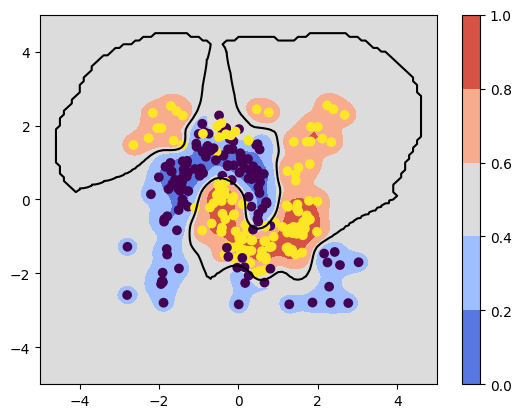

In [4]:
K_new = deepcopy(K)
for sample, lbl in zip(X_new, y_new): 
    sim = pairwise_kernels(zz, sample.reshape(1, -1), metric='rbf', gamma=10).squeeze()
    K_new[:, lbl] = K_new[:, lbl] + sim

probas = K_new / K_new.sum(-1, keepdims=True)
plt.contourf(xx, yy, probas[:, 1].reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.contour(xx, yy, probas[:, 1].reshape(xx.shape), levels=[0.5], colors='k')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.show()

### GP-based Update
The GP-based approach has the following benefits:
- scales well with high number of samples and dimensions
- no hyperparameters (gamma, prior) by optimizing the length scale directly with training.

The optimization of the length scale works because the model is not able to overfit the length scale to zero.
This is because 
1. The RFF features are not perfect. This regularizes the length scale and stops it from collapsing to zero. Improving the RFF approximation can lead to an overfitting of the length scale.
2. Alternatively, we also have a regularization in our loss function with weight decay. A high weight decay leads to a bigger length scale since it does not allow gamma (inverse of the length scale) to become infinitely large.
3. We can end-to-end optimize the model, when fine-tuning in a specfic domain

In [5]:
from lightning import LightningModule, Trainer
from lightning.pytorch.callbacks import Callback
from torch.optim import Optimizer

class TrackLenghtScale(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.input_scale_list = []
        self.input_scale_grad_list = []
        self.length_scale_list = []

    def on_after_backward(self, trainer: Trainer, pl_module: LightningModule):
        input_scale = deepcopy(pl_module.model.random_features.input_scale.item())
        input_scale_grad = pl_module.model.random_features.input_scale.grad.item()
        length_scale = 1 / input_scale**2

        self.input_scale_list.append(input_scale)
        self.input_scale_grad_list.append(input_scale_grad)
        self.length_scale_list.append(length_scale)

/home/dhuseljic/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
from lightning import Trainer
from dal_toolbox.models.sngp import SNGPModel, RandomFeatureGaussianProcess
torch.manual_seed(0)
np.random.seed(0)

num_inducing = 1024
kernel_scale = 1

scale_random_features = True
mean_field_factor = np.pi / 8
net = RandomFeatureGaussianProcess(
    in_features=2, 
    out_features=2,
    num_inducing=num_inducing, 
    kernel_scale=kernel_scale,
    scale_random_features=scale_random_features,
    optimize_kernel_scale=True,
    mean_field_factor=mean_field_factor
)
num_epochs = 200
param_dicts = [
    {"params": [p for n, p in net.named_parameters() if n != 'random_features.input_scale']},
    {"params": [p for n, p in net.named_parameters() if n == 'random_features.input_scale'], 'weight_decay': 0.01}
]
# optimizer = torch.optim.SGD(param_dicts, lr=1e-1, weight_decay=1e-2)
optimizer = torch.optim.RAdam(param_dicts, lr=1e-2, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = SNGPModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

print((1 / model.model.random_features.input_scale)**2)
length_scale_tracker = TrackLenghtScale()
trainer = Trainer(
    max_epochs=num_epochs, 
    callbacks=[length_scale_tracker]
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
trainer.fit(model, train_loader)
print((1 / model.model.random_features.input_scale)**2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                         | Params
---------------------------------------------------------------
0 | model         | RandomFeatureGaussianProcess | 2.0 K 
1 | loss_fn       | CrossEntropyLoss             | 0     
2 | train_metrics | ModuleDict                   | 0     
3 | val_metrics   | ModuleDict                   | 0     
---------------------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


tensor(1., grad_fn=<PowBackward0>)
Epoch 1:  33%|███▎      | 2/6 [00:00<00:00, 324.93it/s, v_num=126, train_loss=0.689]

Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 389.93it/s, v_num=126, train_loss=0.221]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 258.58it/s, v_num=126, train_loss=0.221]
tensor(0.4867, grad_fn=<PowBackward0>)


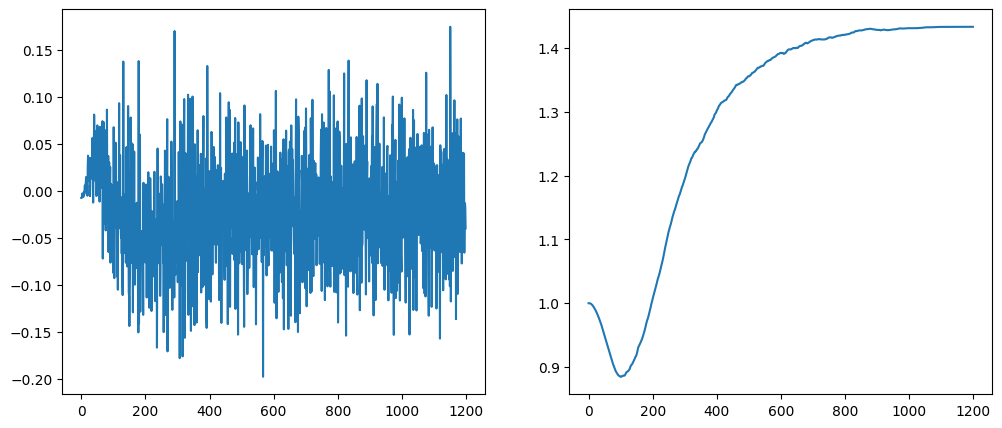

In [51]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(length_scale_tracker.input_scale_grad_list)
plt.subplot(122)
plt.plot(length_scale_tracker.input_scale_list)
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:  52%|█████▎    | 42/80 [00:00<00:00, 393.65it/s]

Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 391.33it/s]


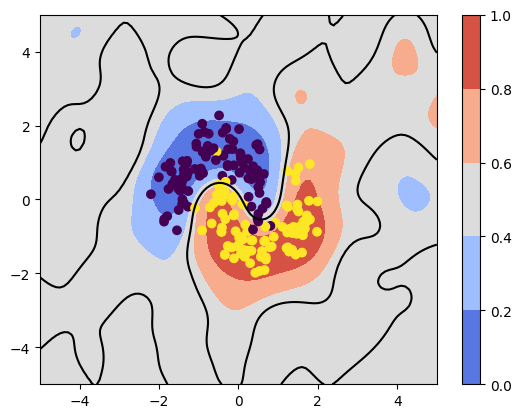

In [52]:
domain = 5
xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 101), torch.linspace(-domain, domain, 201))
zz = torch.stack((xx.ravel(), yy.ravel()), dim=1)

predictions = trainer.predict(model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 391.33it/s]


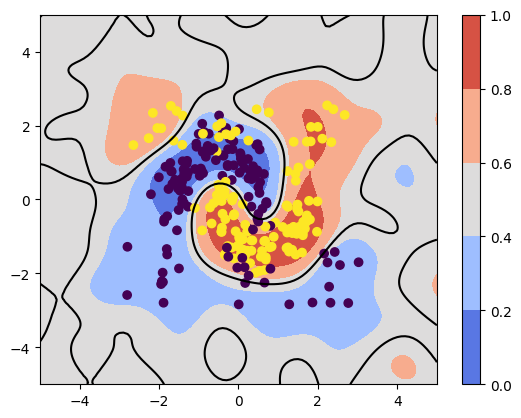

In [53]:
new_model = deepcopy(model)
update_loader = DataLoader(new_ds, batch_size=256)
new_model.update_posterior(update_loader, lmb=1, gamma=1, likelihood='gaussian')

predictions = trainer.predict(new_model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)

### Laplace-based Update


In [28]:
from lightning import Trainer
from dal_toolbox.models.laplace import LaplaceLayer, LaplaceModel

class Net(torch.nn.Module):
    def __init__(self, mean_field_factor):
        super().__init__()
        self.layer1 = nn.Linear(2, 100)
        self.layer2 = LaplaceLayer(in_features=100, out_features=2, mean_field_factor=mean_field_factor)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x, return_features=return_features)
        return x
    
    def forward_mean_field(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2.forward_mean_field(x)
        return x


In [29]:

torch.manual_seed(0)
np.random.seed(0)

mean_field_factor = 10
# net = LaplaceLayer(in_features=2, out_features=2, mean_field_factor=mean_field_factor)
net = Net(mean_field_factor=mean_field_factor)

num_epochs = 200
optimizer = torch.optim.RAdam(net.parameters(), lr=1e-2, weight_decay=0.00)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = LaplaceModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

trainer = Trainer(max_epochs=num_epochs)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 502   
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
502       Trainable params
0         Non-trainable params
502       Total params
0.002     Total estimated model params size (MB)


Epoch 2:  33%|███▎      | 2/6 [00:00<00:00, 440.97it/s, v_num=123, train_loss=0.620]

Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 425.59it/s, v_num=123, train_loss=0.0207] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 6/6 [00:00<00:00, 352.46it/s, v_num=123, train_loss=0.0207]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:  25%|██▌       | 20/80 [00:00<00:00, 623.04it/s]

Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 322.03it/s]


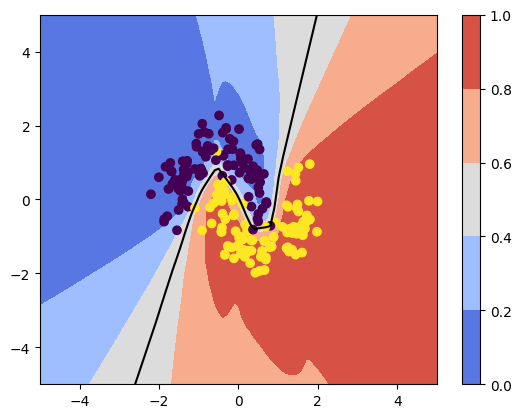

In [30]:
domain = 5
xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 101), torch.linspace(-domain, domain, 201))
zz = torch.stack((xx.ravel(), yy.ravel()), dim=1)

model.set_mean_field_factor(100)
predictions = trainer.predict(model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:  31%|███▏      | 25/80 [00:00<00:00, 593.38it/s]

Predicting DataLoader 0: 100%|██████████| 80/80 [00:00<00:00, 599.18it/s]


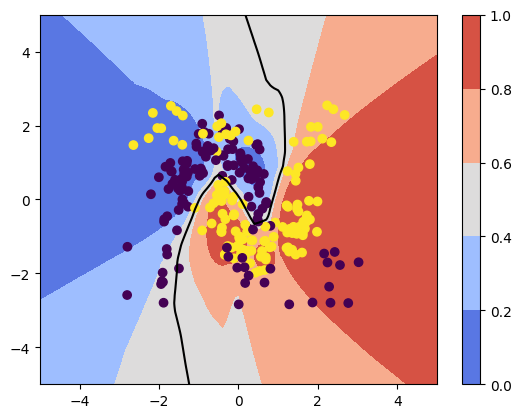

In [33]:
new_model = deepcopy(model)
update_loader = DataLoader(new_ds, batch_size=256)
new_model.update_posterior(update_loader, lmb=10)

predictions = trainer.predict(new_model, DataLoader(TensorDataset(zz, zz), batch_size=256))
logits = torch.cat([pred[0] for pred in predictions])
probas = logits.softmax(-1)[:, 1]

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)
plt.contour(xx, yy, probas.reshape(xx.shape), levels=[0.5], colors='k')
plt.contourf(xx, yy, probas.reshape(xx.shape), cmap='coolwarm', levels=np.linspace(0, 1, 6))
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new)

## SSL Features

In [16]:
from dal_toolbox.datasets import CIFAR10, CIFAR100
from dal_toolbox.datasets.utils import PlainTransforms

dino_model_name = 'dinov2_vitl14' # 300 M params
dino_model = torch.hub.load('facebookresearch/dinov2', dino_model_name)
cifar10 = CIFAR10('/datasets', transforms=PlainTransforms(resize=(224, 224)))
cifar100 = CIFAR100('/datasets', transforms=PlainTransforms(resize=(224, 224)))

Using cache found in /home/dhuseljic/.cache/torch/hub/facebookresearch_dinov2_main


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [17]:
from tqdm.auto import tqdm

class DinoFeatureDataset:

    def __init__(self, dino_model, dataset, normalize_features=False, device='cuda'):
        features, labels = self.get_dino_features(dino_model, dataset, device)

        if normalize_features:
            features_mean = features.mean(0)
            features_std = features.std(0) + 1e-9
            features = (features - features_mean) / features_std

        self.features = features
        self.labels = labels
    
    def __len__(self) -> int:
        return len(self.features)

    def __getitem__(self, idx: int):
        return self.features[idx], self.labels[idx]

    @torch.no_grad()
    def get_dino_features(self, dino_model, dataset, device):
        dataloader = DataLoader(dataset, batch_size=512, num_workers=4)

        features = []
        labels = []
        dino_model.to(device)
        for batch in tqdm(dataloader):
            features.append(dino_model(batch[0].to(device)).to('cpu'))
            labels.append(batch[-1])
        features = torch.cat(features)
        labels = torch.cat(labels)
        return features, labels

In [18]:
train_ds = DinoFeatureDataset(dino_model, cifar10.train_dataset)
val_ds = DinoFeatureDataset(dino_model, cifar10.val_dataset)
test_ds = DinoFeatureDataset(dino_model, cifar10.test_dataset)
ood_ds = DinoFeatureDataset(dino_model, cifar100.test_dataset)

  0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


### Kernel-based Model

In [79]:
from sklearn.metrics import pairwise_kernels

def k_func(samples, X_train, y_train, gamma=None, prior=1e-3, num_classes=10):
    S = pairwise_kernels(samples, X_train, metric='rbf', gamma=gamma)

    K = []
    for sim in S:
        k_vec = np.zeros(num_classes) + prior
        for i_cls in range(num_classes):
            sim_cls = sim[y_train == i_cls]
            k_vec[i_cls] += np.sum(sim_cls)
        K.append(k_vec)
    return np.array(K)

In [88]:
from dal_toolbox.metrics import Accuracy, OODAUROC, AdaptiveCalibrationError, OODAUPR
from skactiveml.classifier import ParzenWindowClassifier

# Difficult to optimize this hyperparameters, uncertainty modeling is also bad
N, n_features = train_ds.features.shape
variances = train_ds.features.var(dim=0).numpy()
gamma = ParzenWindowClassifier._calculate_mean_gamma(N, variances, n_features)
# gamma = 1e-2
prior = 1e-3

K_test = k_func(test_ds.features, train_ds.features, train_ds.labels, gamma=gamma, prior=prior)
test_probas = torch.from_numpy(K_test / K_test.sum(-1, keepdims=True)).float()
test_logits = test_probas.log()
test_entropies = - torch.sum(test_probas * test_probas.log(), dim=-1)

K_ood = k_func(ood_ds.features, train_ds.features, train_ds.labels, gamma=gamma, prior=prior)
ood_probas = torch.from_numpy(K_ood / K_ood.sum(-1, keepdims=True)).float()
ood_entropies = - torch.sum(ood_probas * ood_probas.log(), dim=-1)

print({
    'ACC': Accuracy()(test_logits, test_ds.labels),
    'ACE': AdaptiveCalibrationError()(test_logits, test_ds.labels),
    'AUROC': OODAUROC()(test_entropies, ood_entropies),
    'AUPR': OODAUPR()(test_entropies, ood_entropies),
})

{'ACC': tensor(0.9679), 'ACE': tensor(0.0740), 'AUROC': tensor(0.9504), 'AUPR': tensor(0.9460)}


### GP-based Model

In [90]:
from lightning import LightningModule, Trainer
from lightning.pytorch.callbacks import Callback

class TrackLenghtScale(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.input_scale_list = []
        self.input_scale_grad_list = []
        self.length_scale_list = []

    def on_after_backward(self, trainer: Trainer, pl_module: LightningModule):
        input_scale = deepcopy(pl_module.model.random_features.input_scale.item())
        input_scale_grad = pl_module.model.random_features.input_scale.grad.item()
        length_scale = 1 / input_scale**2

        self.input_scale_list.append(input_scale)
        self.input_scale_grad_list.append(input_scale_grad)
        self.length_scale_list.append(length_scale)

In [93]:
from lightning import Trainer
from dal_toolbox.models.sngp import SNGPModel, RandomFeatureGaussianProcess
torch.set_float32_matmul_precision('medium')

num_inducing = 1024
kernel_scale = 1
scale_random_features = False
mean_field_factor = 100
net = RandomFeatureGaussianProcess(
    in_features=1024, 
    out_features=10,
    num_inducing=num_inducing, 
    kernel_scale=kernel_scale,
    scale_random_features=scale_random_features,
    mean_field_factor=mean_field_factor
)
num_epochs = 10
param_dicts = [
    {"params": [p for n, p in net.named_parameters() if n != 'random_features.input_scale']},
    {"params": [p for n, p in net.named_parameters() if n == 'random_features.input_scale']}
]
optimizer = torch.optim.SGD(param_dicts, lr=1e-1, weight_decay=1e-2, momentum=0.9)
# optimizer = torch.optim.Adam(param_dicts, lr=1e-3, weight_decay=1e-1)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = SNGPModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

print((1 / model.model.random_features.input_scale)**2)
tracker = TrackLenghtScale()
trainer = Trainer(max_epochs=num_epochs, callbacks=[tracker])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
trainer.fit(model, train_loader)
print((1 / model.model.random_features.input_scale)**2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                         | Params
---------------------------------------------------------------
0 | model         | RandomFeatureGaussianProcess | 10.2 K
1 | loss_fn       | CrossEntropyLoss             | 0     
2 | train_metrics | ModuleDict                   | 0     
3 | val_metrics   | ModuleDict                   | 0     
---------------------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)


tensor(1., grad_fn=<PowBackward0>)
Epoch 0:   2%|▏         | 29/1406 [00:00<00:02, 658.78it/s, v_num=552, train_loss=0.0784]

Epoch 9: 100%|██████████| 1406/1406 [00:01<00:00, 708.03it/s, v_num=552, train_loss=0.0485] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1406/1406 [00:01<00:00, 704.58it/s, v_num=552, train_loss=0.0485]
tensor(3.2640, grad_fn=<PowBackward0>)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 378.09it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0:  85%|████████▌ | 17/20 [00:00<00:00, 360.69it/s]

Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 358.54it/s]
{'ACC': tensor(0.9802), 'ACE': tensor(0.0411), 'AUROC': tensor(0.9836), 'AUPR': tensor(0.9817)}


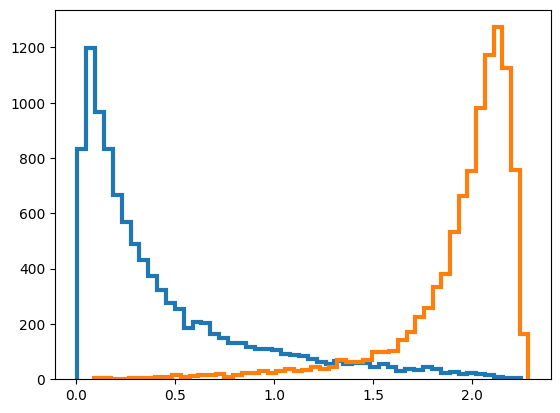

In [107]:
from dal_toolbox.metrics import Accuracy, OODAUROC, AdaptiveCalibrationError, OODAUPR

test_loader = DataLoader(test_ds, batch_size=512)
test_predictions = trainer.predict(model, dataloaders=test_loader)
test_logits = torch.cat([pred[0] for pred in test_predictions])
test_labels = torch.cat([pred[1] for pred in test_predictions])
test_log_probas = test_logits.log_softmax(dim=-1)
test_entropies = torch.sum(- test_log_probas.exp() * test_log_probas, dim=-1)

ood_loader = DataLoader(ood_ds, batch_size=512)
ood_predictions = trainer.predict(model, dataloaders=ood_loader)
ood_logits = torch.cat([pred[0] for pred in ood_predictions])
ood_log_probas = ood_logits.log_softmax(dim=-1)
ood_entropies = torch.sum(- ood_log_probas.exp() * ood_log_probas, dim=-1)

print({
    'ACC': Accuracy()(test_logits, test_labels),
    'ACE': AdaptiveCalibrationError()(test_logits, test_labels),
    'AUROC': OODAUROC()(test_entropies, ood_entropies),
    'AUPR': OODAUPR()(test_entropies, ood_entropies),
})

plt.hist(test_entropies, bins=50, histtype='step', linewidth=3)
plt.hist(ood_entropies, bins=50, histtype='step', linewidth=3)
plt.show()

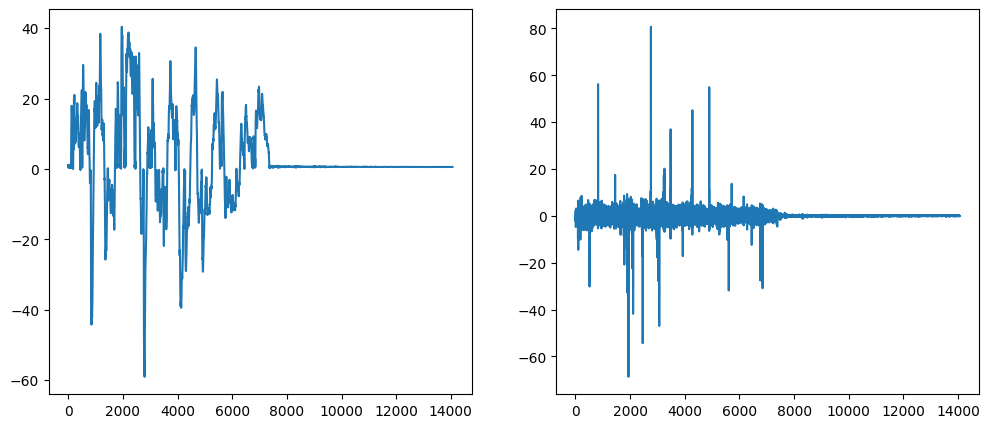

: 

In [108]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(tracker.input_scale_list) 
plt.subplot(122)
plt.plot(tracker.input_scale_grad_list)

In [64]:
from torch.utils.data import Subset

train_indices = np.random.permutation(len(train_ds))[:100]
train_ds_subset = Subset(train_ds, indices=train_indices)

In [140]:
from lightning import Trainer
from dal_toolbox.models.sngp import SNGPModel, RandomFeatureGaussianProcess
torch.set_float32_matmul_precision('medium')

num_inducing = 1024
kernel_scale = 1
scale_random_features = True
mean_field_factor = np.pi / 8
net = RandomFeatureGaussianProcess(
    in_features=1024, 
    out_features=10,
    num_inducing=num_inducing, 
    kernel_scale=kernel_scale,
    scale_random_features=scale_random_features,
    mean_field_factor=mean_field_factor
)
num_epochs = 10
param_dicts = [
    {"params": [p for n, p in net.named_parameters() if n != 'random_features.input_scale']},
    {"params": [p for n, p in net.named_parameters() if n == 'random_features.input_scale']}
]
# optimizer = torch.optim.SGD(param_dicts, lr=1e-1, weight_decay=5e-2, momentum=0.9)
# optimizer = torch.optim.AdamW(param_dicts, lr=1e-2, weight_decay=1e-5)
optimizer = torch.optim.LBFGS(net.parameters(), lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
model = SNGPModel(net, optimizer=optimizer, lr_scheduler=lr_scheduler)

tracker = TrackLenghtScale()
trainer = Trainer(max_epochs=num_epochs, callbacks=[tracker])
train_loader = DataLoader(train_ds_subset, batch_size=32, shuffle=True, drop_last=True)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                         | Params
---------------------------------------------------------------
0 | model         | RandomFeatureGaussianProcess | 10.2 K
1 | loss_fn       | CrossEntropyLoss             | 0     
2 | train_metrics | ModuleDict                   | 0     
3 | val_metrics   | ModuleDict                   | 0     
---------------------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)


Epoch 0:  67%|██████▋   | 2/3 [00:00<00:00, 34.80it/s, v_num=547, train_loss=1.990]

Epoch 9: 100%|██████████| 3/3 [00:00<00:00, 11.50it/s, v_num=547, train_loss=0.0114] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 3/3 [00:00<00:00, 10.52it/s, v_num=547, train_loss=0.0114]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 396.66it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 393.24it/s]
{'ACC': tensor(0.5932), 'ACE': tensor(0.0591), 'AUROC': tensor(0.7197), 'AUPR': tensor(0.6678)}


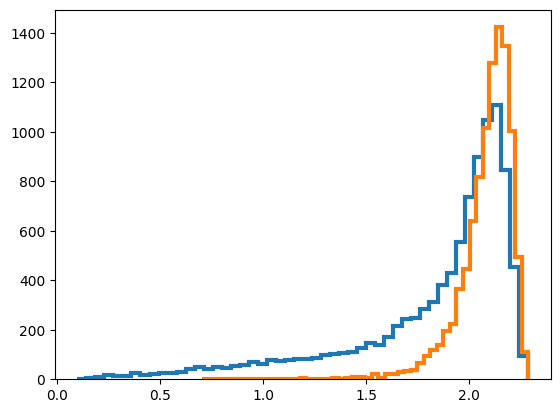

In [141]:
from dal_toolbox.metrics import Accuracy, OODAUROC, AdaptiveCalibrationError, OODAUPR

test_loader = DataLoader(test_ds, batch_size=512)
test_predictions = trainer.predict(model, dataloaders=test_loader)
test_logits = torch.cat([pred[0] for pred in test_predictions])
test_labels = torch.cat([pred[1] for pred in test_predictions])
test_log_probas = test_logits.log_softmax(dim=-1)
test_entropies = torch.sum(- test_log_probas.exp() * test_log_probas, dim=-1)

ood_loader = DataLoader(ood_ds, batch_size=512)
ood_predictions = trainer.predict(model, dataloaders=ood_loader)
ood_logits = torch.cat([pred[0] for pred in ood_predictions])
ood_log_probas = ood_logits.log_softmax(dim=-1)
ood_entropies = torch.sum(- ood_log_probas.exp() * ood_log_probas, dim=-1)

print({
    'ACC': Accuracy()(test_logits, test_labels),
    'ACE': AdaptiveCalibrationError()(test_logits, test_labels),
    'AUROC': OODAUROC()(test_entropies, ood_entropies),
    'AUPR': OODAUPR()(test_entropies, ood_entropies),
})

plt.hist(test_entropies, bins=50, histtype='step', linewidth=3)
plt.hist(ood_entropies, bins=50, histtype='step', linewidth=3)
plt.show()